In [174]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta



In [176]:
def get_binance_minute_data(symbol: str, start_time: str, end_time: str) -> pd.DataFrame:
    url = 'https://api.binance.com/api/v2/klines'
    interval = '10m'
    start_ms = int(pd.to_datetime(start_time).timestamp() * 1000)
    end_ms   = int(pd.to_datetime(end_time).timestamp() * 1000)
    
    frames = []
    while start_ms < end_ms:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': start_ms,
            'endTime': end_ms,
            'limit': 1000
        }
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        data = resp.json()
        if not data:
            break
        
        df = pd.DataFrame(data, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume',
            'close_time', 'quote_asset_volume', 'trades',
            'taker_buy_base_volume', 'taker_buy_quote_volume', 'ignore'
        ])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        # keep only the close price as float
        frames.append(df[['close']].astype(float).rename(columns={'close': symbol}))
        
        # advance start to one ms after last candle
        last_ts = int(data[-1][0])
        start_ms = last_ts + 1
        time.sleep(0.2)  # throttle to avoid API limits
    
    if frames:
        return pd.concat(frames)
    else:
        return pd.DataFrame(columns=[symbol])


def get_top_20_minute_closes(start_time: str, end_time: str, tickers: list) -> pd.DataFrame:
    all_dfs = []
    for symbol in tickers:
        print(f"Fetching {symbol} from {start_time} to {end_time} …")
        df_symbol = get_binance_minute_data(symbol, start_time, end_time)
        all_dfs.append(df_symbol)
    
    # merge on index (timestamp), outer join to keep all times
    if all_dfs:
        merged = pd.concat(all_dfs, axis=1)
        # optionally sort the index
        merged.sort_index(inplace=True)
        return merged
    else:
        return pd.DataFrame()


In [178]:
top_symbols = [
        'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'XRPUSDT',
        'DOGEUSDT', 'ADAUSDT', 'AVAXUSDT', 'DOTUSDT', 'LINKUSDT',
        'TRXUSDT', 'MATICUSDT', 'SHIBUSDT', 'LTCUSDT', 'WBTCUSDT',
        'TONUSDT', 'OPUSDT', 'ARBUSDT', 'XLMUSDT', 'ATOMUSDT'
    ]

top_symbols2 = [
    "BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT",
    "DOGEUSDT", "SOLUSDT", "MATICUSDT", "DOTUSDT", "LINKUSDT",
    "LTCUSDT", "BCHUSDT", "TRXUSDT", "UNIUSDT", "AVAXUSDT",
    "FILUSDT", "NEARUSDT", "APTUSDT", "APEUSDT", "ARBUSDT",
    "MANAUSDT", "SANDUSDT", "ATOMUSDT", "OPUSDT", "FTMUSDT"
]

short_data = top_symbols2

In [180]:
#df_merged = get_top_20_minute_closes("2025-01-01 00:00:00", "2025-01-06 00:00:00", short_data)
#df_merged.to_csv("raw_data.csv", index = False)

df_merged = pd.read_csv("raw_data.csv")
df_merged.head(3)


,BTCUSDT,ETHUSDT,BNBUSDT,XRPUSDT,ADAUSDT,DOGEUSDT,SOLUSDT,MATICUSDT,DOTUSDT,LINKUSDT,...,FILUSDT,NEARUSDT,APTUSDT,APEUSDT,ARBUSDT,MANAUSDT,SANDUSDT,ATOMUSDT,OPUSDT,FTMUSDT
0,93656.18,3348.50,704.01,2.0967,0.8512,0.31775,190.51,NaN,6.674,20.09,...,4.976,4.942,8.76,1.211,0.7254,0.4698,0.5486,6.224,1.763,0.6904
1,93761.90,3349.43,704.63,2.0979,0.8521,0.31856,190.72,NaN,6.678,20.06,...,4.986,4.942,8.73,1.212,0.7258,0.4702,0.5494,6.226,1.766,0.6858
2,93885.01,3356.09,706.21,2.0996,0.8541,0.31886,191.28,NaN,6.689,20.11,...,4.996,4.953,8.73,1.218,0.7268,0.4713,0.5502,6.236,1.778,0.6816


In [182]:
import numpy as np
from numpy.typing import NDArray
import seaborn as sns


from scipy.linalg import fractional_matrix_power
from scipy.linalg import sqrtm

In [184]:
cols = df_merged.dropna(axis = 1).copy()
price = df_merged.dropna(axis = 1).copy().values
#price = np.diff(np.log(price2), axis=0)
np.mean(price, axis=1)

demeaned_price = (price - np.mean(price, axis=1).reshape(-1, 1)) / np.std(price, axis = 1).reshape(-1, 1)


In [198]:
def generate_A(matrix: NDArray, lag : float) -> NDArray:
    matrix = sort_matrix(matrix)
    T = matrix.shape[1]
    Y = matrix[:, lag:]
    X = matrix[:, :(T-lag)]

    A = np.linalg.inv(X @ X.T) @ Y @ X.T     # predicted rückwärts, in die Vergangenheit 
    return A, X, Y



def sort_matrix(matrix: NDArray) -> NDArray:
    #sorts Matrix size n x T with T >> n (n Assets, T timesteps)
    if matrix.shape[0] > matrix.shape[1]:
        return matrix.T
    else:
        return matrix



def get_weights(matrix : NDArray, lag: float) -> NDArray:
    A, X, Y = generate_A(matrix, 20)
    
    C = X @ X.T                                          #C is size n x n (current cov Matrix)
    C_05 = np.linalg.inv(sqrtm(C)).real

    opt_ = C_05 @A @ (X @ X.T) @A.T @ C_05

    value, vector = np.linalg.eigh(opt_)

    min_weights_z = vector[value == np.max(value)]
    min_weights_x = C_05 @ min_weights_z.T
    

    return min_weights_x


def optimized_weights(matrix:NDArray, lag_end: float, skipper:float, cutoff:float) -> NDArray:
    n = sort_matrix(matrix).shape[0]
    base = np.ones(n).reshape(-1, 1) 
    weighting = base * 0
    
    for i in range(1, lag_end//skipper):
        i *= skipper
        weighting += get_weights(matrix, i)

    weighting = weighting / (np.sum(weighting))
    return weighting

In [206]:
w3 = optimized_weights(demeaned_price, 180, 1, 1)
w2 = get_weights(demeaned_price, 1)


w_5l = sorted(w3, reverse=True)[9]
o_w3 = np.where(w3 >= w_5l, 1, 0)
#w3c = w3 * o_w3 
#w3c = wr3c / np.sum(w3c)
#get cut off weights

np.sum(w3)

array([[ 4.31337770e-02],
       [ 1.01755227e-01],
       [-5.04567072e-01],
       [-2.18471479e+01],
       [ 5.85787766e+01],
       [-1.13478294e+02],
       [-1.15661280e+00],
       [-3.11077741e+01],
       [-2.00572153e+00],
       [-5.30901758e-01],
       [ 6.44012592e-01],
       [-9.14658302e+01],
       [-1.18123386e+01],
       [ 8.49404117e+00],
       [-2.56662564e+01],
       [ 1.89924374e+01],
       [-5.75440872e+00],
       [ 5.71812224e+02],
       [-2.25057163e+02],
       [-1.89530234e+02],
       [ 3.44214224e+01],
       [-4.76395642e+01],
       [ 9.94236654e+01],
       [-2.39546541e+01]])

In [148]:
port = demeaned_price @ w3
visuals = pd.DataFrame(port, columns=["port"])


<Axes: >

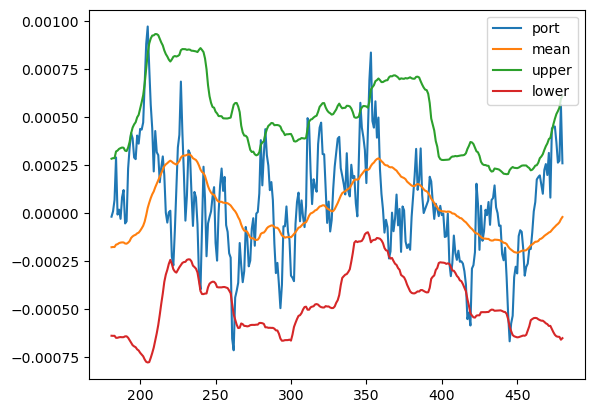

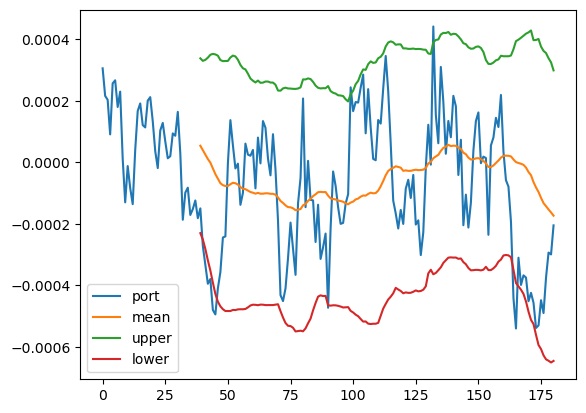

In [150]:
visuals["mean"] = visuals["port"].rolling(40).mean()
visuals["upper"] = visuals["mean"] + visuals["port"].rolling(40).std() * 2
visuals["lower"] = visuals["mean"] - visuals["port"].rolling(40).std() * 2

visuals.iloc[-300:, :].plot()
visuals.iloc[-600:-300, :].plot()


<Axes: >

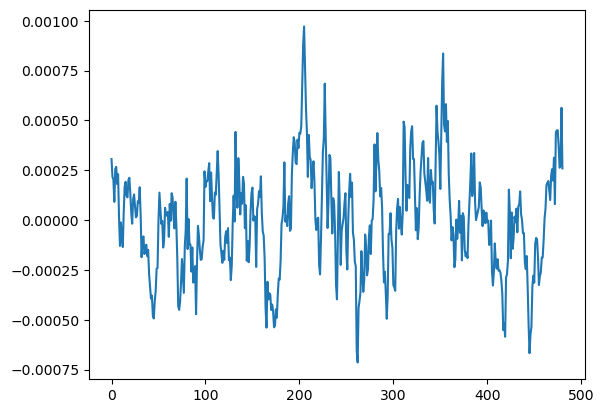

In [152]:
visuals["port"].plot()

<Axes: >

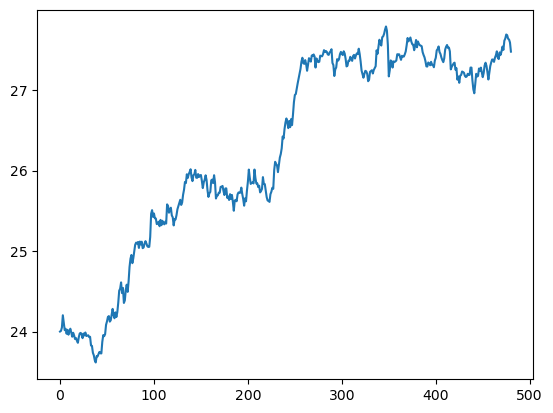

In [168]:
import seaborn as sns

sns.lineplot(np.sum(df_merged / df_merged.iloc[0, :], axis = 1))


<Axes: >

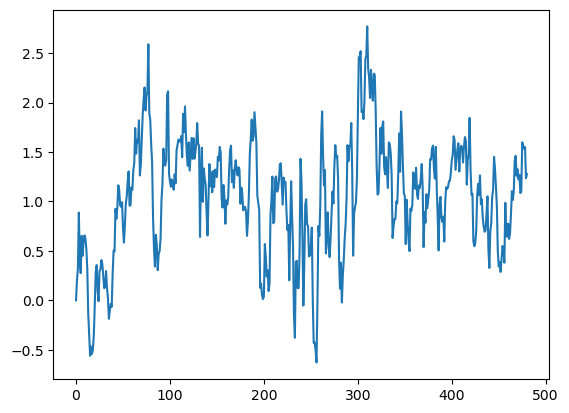

In [79]:
sns.lineplot(diff)
